In [879]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [880]:
#reading in the dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

## balacing the dataset

To solve the imbalanced class  problem I would suggest three different approaches: Upsample the class with fewer observations, in this case, upsample the "stroke" observations until you reach the same number as the "no stroke" class.Downsample the class with most observations, in this case, downsample the "no stroke" observations until you reach the same number as the "stroke" class. Or choose a classifier that can deal with imbalanced classes. Some of them are robust to this problem by weighting the classes (SVC, decision trees…).

<AxesSubplot:>

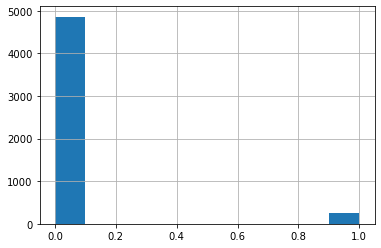

In [881]:
df["stroke"].hist()

In [882]:
df_stroke = df[df["stroke"]==1]
#df_stroke["age"].hist()

In [883]:
df_no_stroke = df[df["stroke"]==0].sample(250).reset_index(drop=True)

In [884]:
df = pd.concat([df_stroke,df_no_stroke]).reset_index(drop=True)

<AxesSubplot:>

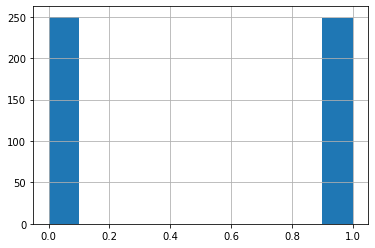

In [885]:
df["stroke"].hist()

## exploartion

In [886]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [887]:
#BMI is the only variable with null values
df.isnull().sum()

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  48
smoking_status        0
stroke                0
dtype: int64

In [888]:
df = df.fillna(df.mean())

In [889]:
df.isnull().sum().sum()

0

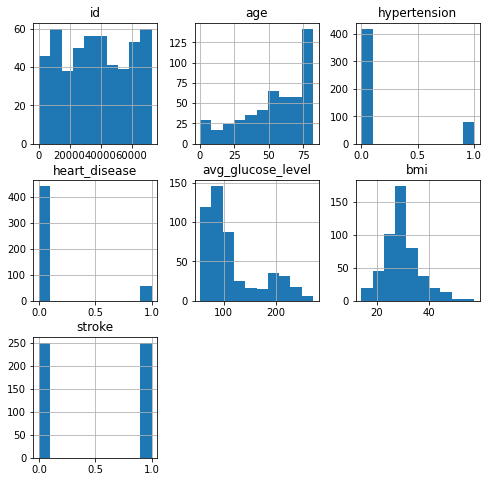

In [890]:
hist = df.hist(figsize=(8,8))

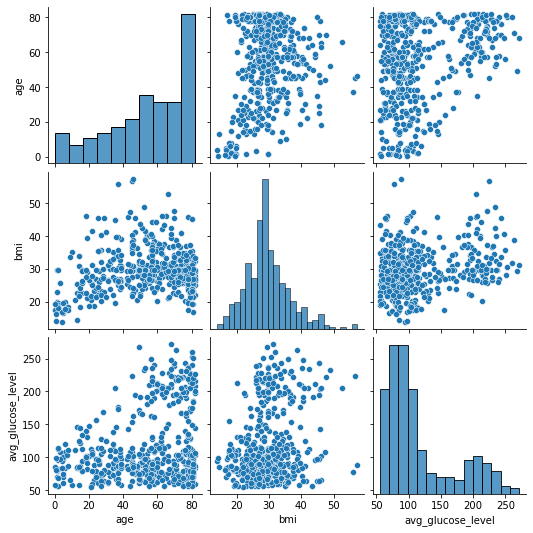

In [891]:
sns_plot = sns.pairplot(df, vars = ["age","bmi","avg_glucose_level"])
plt.show()

In [892]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,36963.547094,54.404088,0.160321,0.114228,116.398116,29.521951,0.498998
std,21394.104140,23.059568,0.367271,0.318408,53.907883,6.721101,0.500501
min,210.000000,0.240000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,18284.000000,38.000000,0.000000,0.000000,77.680000,25.600000,0.000000
50%,36471.000000,58.000000,0.000000,0.000000,96.970000,29.521951,0.000000
75%,55715.500000,75.000000,0.000000,0.000000,137.630000,32.750000,1.000000
max,72918.000000,82.000000,1.000000,1.000000,271.740000,57.300000,1.000000


## bmi outlier detection

<AxesSubplot:xlabel='bmi'>

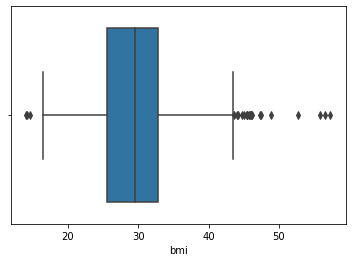

In [893]:
#https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
#shows tons of outliers 
sns.boxplot(x=df['bmi'])

# more exploration

In [894]:
df["smoking_status"].value_counts()

never smoked       191
Unknown            134
formerly smoked    112
smokes              62
Name: smoking_status, dtype: int64

In [895]:
df["ever_married"].value_counts()

Yes    381
No     118
Name: ever_married, dtype: int64

In [896]:
df["work_type"].value_counts()

Private          294
Self-employed    101
Govt_job          69
children          34
Never_worked       1
Name: work_type, dtype: int64

In [897]:
df[df["work_type"]=="children"]["age"].describe()
#work_type == children indicate that the id is of a kid
#should kids be dropped?? Only above 18 years -- but only 700 rows

count    34.000000
mean      4.754118
std       3.956174
min       0.240000
25%       1.680000
50%       4.000000
75%       6.000000
max      14.000000
Name: age, dtype: float64

In [898]:
df["Residence_type"].value_counts()

Urban    253
Rural    246
Name: Residence_type, dtype: int64

In [899]:
df["gender"].value_counts()

Female    281
Male      218
Name: gender, dtype: int64

In [900]:
df = df[df.gender !="Other"]

In [901]:
df["gender"].value_counts()

Female    281
Male      218
Name: gender, dtype: int64

# diabetes clustering

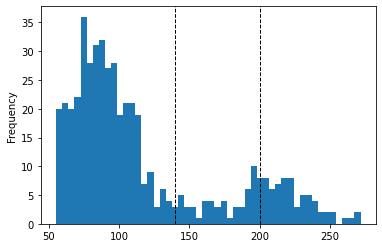

In [902]:
#it seems like that it has the unite of mg/dL (milligram/decilitre).
#https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451
df["avg_glucose_level"].plot.hist(bins=50)
plt.axvline(140, color='k', linestyle='dashed', linewidth=1) #between 140-200 indicates prediabetes
plt.axvline(200, color='k', linestyle='dashed', linewidth=1) #more than 200 indicate diabetes 

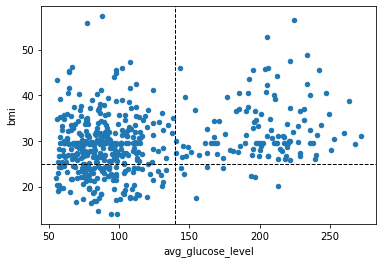

In [903]:
#we could classify diabetes by clustering 
df.plot.scatter("avg_glucose_level","bmi")
plt.axvline(140, color='k', linestyle='dashed', linewidth=1) #between 140-200 indicates prediabetes
plt.axhline(25, color='k', linestyle='dashed', linewidth=1) #25 above indicates overweight
#https://netdoktor.dk/interactive/interactivetests/bmi.php

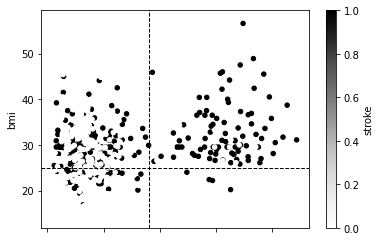

In [904]:
df.plot.scatter("avg_glucose_level","bmi",c="stroke")
plt.axvline(140, color='k', linestyle='dashed', linewidth=1) 
plt.axhline(25, color='k', linestyle='dashed', linewidth=1)

## K-means "elbow method" for clustering diabetes

In [905]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df[["avg_glucose_level","bmi"]])
    distortions.append(kmeanModel.inertia_)
#inertia_ is the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if relevant

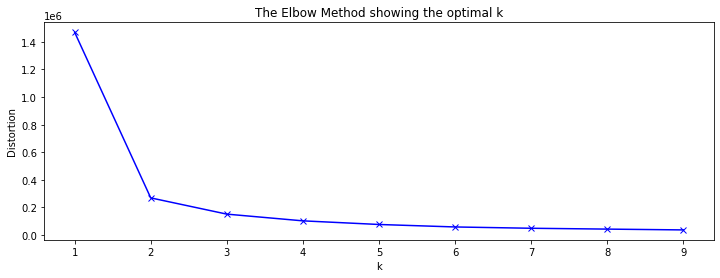

In [906]:
plt.figure(figsize=(12,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

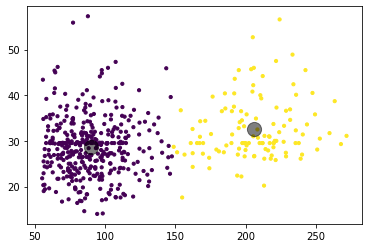

In [907]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[["avg_glucose_level","bmi"]])
y_kmeans = kmeans.predict(df[["avg_glucose_level","bmi"]]) #labels 

plt.scatter(df["avg_glucose_level"], df["bmi"], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# age avg glukose level clustering

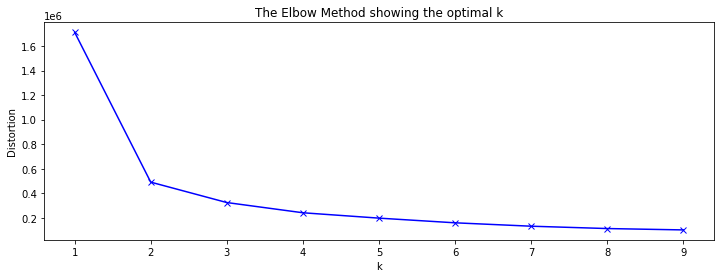

In [908]:
X = df[["age","avg_glucose_level"]]
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(12,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

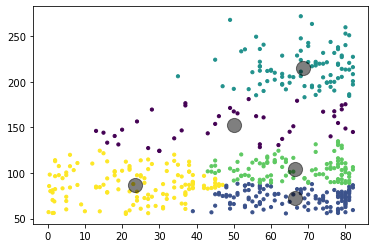

In [909]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X) #labels 

plt.scatter(X["age"], X["avg_glucose_level"], c=y_kmeans, s=10, cmap='viridis') #c=df["stroke"]
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Strokes among groups 

In [910]:
print((df[df["gender"]=="Male"].sum()["stroke"]/df[df["gender"]=="Male"].count()["stroke"])*100)
print((df[df["gender"]=="Female"].sum()["stroke"]/df[df["gender"]=="Female"].count()["stroke"])*100)

49.54128440366973
50.177935943060504


In [911]:
print((df[df["ever_married"]=="Yes"].sum()["stroke"]/df[df["ever_married"]=="Yes"].count()["stroke"])*100)
print((df[df["ever_married"]=="No"].sum()["stroke"]/df[df["ever_married"]=="No"].count()["stroke"])*100)

57.74278215223097
24.576271186440678


In [912]:
print((df[df["Residence_type"]=="Urban"].sum()["stroke"]/df[df["Residence_type"]=="Urban"].count()["stroke"])*100)
print((df[df["Residence_type"]=="Rural"].sum()["stroke"]/df[df["Residence_type"]=="Rural"].count()["stroke"])*100)

53.359683794466406
46.34146341463415


In [913]:
print((df[df["heart_disease"]==1].sum()["stroke"]/df[df["heart_disease"]==1].count()["stroke"])*100)
print((df[df["heart_disease"]==0].sum()["stroke"]/df[df["heart_disease"]==0].count()["stroke"])*100)

82.45614035087719
45.70135746606335


In [914]:
print((df[df["smoking_status"]=="never smoked"].sum()["stroke"]/df[df["smoking_status"]=="never smoked"].count()["stroke"])*100)
print((df[df["smoking_status"]=="Unknown"].sum()["stroke"]/df[df["smoking_status"]=="Unknown"].count()["stroke"])*100)
print((df[df["smoking_status"]=="formerly smoked"].sum()["stroke"]/df[df["smoking_status"]=="formerly smoked"].count()["stroke"])*100)
print((df[df["smoking_status"]=="smokes"].sum()["stroke"]/df[df["smoking_status"]=="smokes"].count()["stroke"])*100)

47.12041884816754
35.07462686567165
62.5
67.74193548387096


# predicting stroke

In [915]:
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [916]:
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

In [917]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [918]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,0,202.21,29.521951,never smoked,1
2,31112,1,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,60182,0,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1


In [925]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

In [920]:
df = df.iloc[:,[1,2,3,4,5,7,8,9,11]]

In [921]:
#scaler = StandardScaler()
#scaler.fit_transform(df)

In [922]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.33, random_state=42)

#### linear regression

In [923]:
reg = LinearRegression().fit(X_train, y_train)

In [933]:
reg.score(X_test, y_test)

0.3182857109461408

#### gaussian NB 

In [926]:
clf = GaussianNB()

In [930]:
clf.fit(X_train, y_train)

C:\Users\naja\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB()

In [934]:
clf.score(X_test,y_test)

0.7393939393939394

In [937]:
print(clf.predict([[0,28,0,0,1,1,100,20]])) #simone

[0]


In [940]:
print(clf.predict([[0,24,0,0,0,1,100,24]])) #naja

[0]
